In [1]:
# import all tools
import numpy as np
from pyspark.sql.functions import explode
from pyspark.sql import Row
import math
from itertools import combinations
import unittest
from pyspark.sql import types as T, SparkSession
from scipy.spatial import distance
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
import numpy as np
from pyspark.sql import Row
import matplotlib.pyplot as plt
import time

Text(0.5, 1.0, 'Data1 Points')

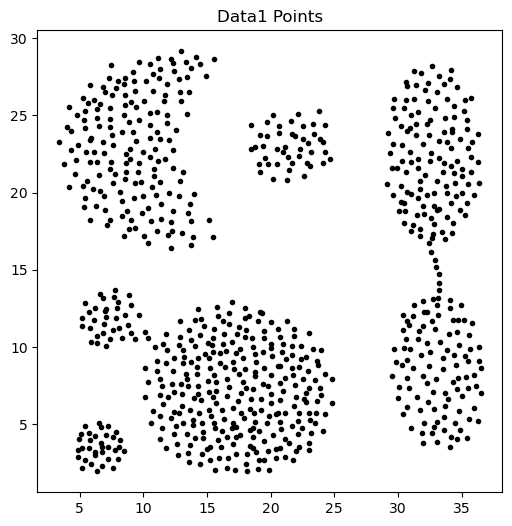

In [2]:
# Test1 data show
# Read the file and split it into a list
with open('788points.txt', 'r') as file:
    lines = file.readlines()

# Initialize an empty list to save coordinates
coordinates = []

# Iterate over each line, parse the coordinates and add them to the list
for line in lines:
    x, y = line.strip().split(',')
    coordinates.append([float(x), float(y)])

# Convert the coordinate list into a Numpy array
coordinates_array = np.array(coordinates)

# Print the result
plt.subplots(figsize=(6, 6))
plt.plot(coordinates_array[:, 0], coordinates_array[:, 1], 'o', markerfacecolor=[0, 0, 0, 1],
             markeredgecolor='k', markersize=3, scalex=1, scaley=1)
plt.title('Data1 Points')

Text(0.5, 1.0, 'Data2 Points')

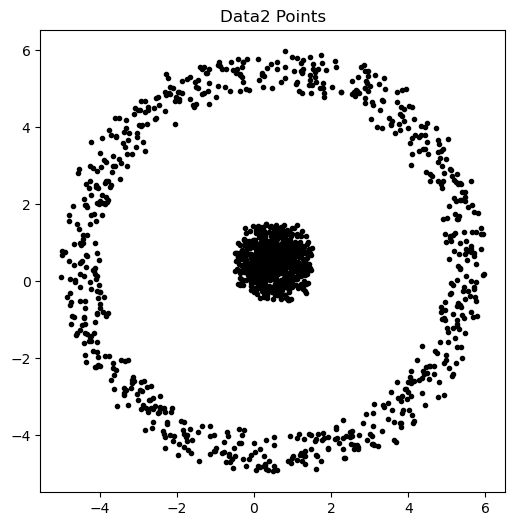

In [3]:
#Test2 data show

#random generate circle
num_samples = 750
theta = np.linspace(0, 2 * np.pi, num_samples)
X1 = np.random.rand(num_samples, 2) + np.transpose([0.5 * np.cos(theta), 0.5 * np.sin(theta) ])
X2 = np.random.rand(num_samples, 2) + np.transpose([5 * np.cos(theta), 5 * np.sin(theta) ])
circle = np.concatenate([X1, X2])

#Print the result
plt.subplots(figsize=(6, 6))
plt.plot(circle[:, 0], circle[:, 1], 'o', markerfacecolor=[0, 0, 0, 1],
             markeredgecolor='k', markersize=3, scalex=1, scaley=1)
plt.title('Data2 Points')

In [4]:
def __distance_from_pivot(pivot, dist, epsilon, operations):
    # This function creates a distance function that computes the distance between a given data point and the pivot point.
    
    # pivot: The pivot point used to compute distances
    # dist: The distance function to calculate distances between points
    # epsilon: The distance threshold for clustering
    # operations: The accumulator for tracking the number of distance computations

    def distance(x):
        # Calculate the distance between the point and the pivot
        pivot_dist = dist(x.value, pivot)
        
        # If the operations accumulator is not None, increment it
        if operations is not None:
            operations.add()

        # Determine the partition index by taking the floor of the distance divided by epsilon
        partition_index = math.floor(pivot_dist / epsilon)
        
        # Create a list of Row objects containing the id, value, and distance from the pivot for the data point
        rows = [Row(id=x.id, value=x.value, pivot_dist=dist(x.value, pivot))]
        
        # Return a list of tuples containing the partition index and the list of rows for the partition index and the next index
        out = [(partition_index, rows),
               (partition_index + 1, rows)]
        return out

    # Return the distance function
    return distance


In [5]:
def __scan(epsilon, dist, operations):
    # This function creates a scan function that finds neighboring data points within epsilon distance.
    
    # epsilon: The distance threshold for clustering
    # dist: The distance function to calculate distances between points
    # operations: The accumulator for tracking the number of distance computations

    def scan(x):
        # The output dictionary will have point id as key and a set of point ids within epsilon distance to the key point id as value.
        out = {}
        
        # 0th index of x is partition_index
        # 1st index of x is a list of data points
        partition_data = x[1]
        partition_len = len(partition_data)

        # Double loop over the data points in the partition
        for i in range(partition_len):
            for j in range(i + 1, partition_len):
                # Increment the operations accumulator if it's not None
                if operations is not None:
                    operations.add()
                
                # If the distance between the two points is less than epsilon, add each to the other's list of neighbors
                if dist(partition_data[i].value, partition_data[j].value) < epsilon:
                    # Add point j to point i's set of neighbors
                    if partition_data[i].id in out:
                        out[partition_data[i].id].add(partition_data[j].id)
                    else:
                        out[partition_data[i].id] = set([partition_data[j].id])
                    
                    # Add point i to point j's set of neighbors
                    if partition_data[j].id in out:
                        out[partition_data[j].id].add(partition_data[i].id)
                    else:
                        out[partition_data[j].id] = set([partition_data[i].id])
        
        # Return a list of Row objects, where each Row contains a point id and the set of its neighbors
        return [Row(item[0], item[1]) for item in out.items()]

    # Return the scan function
    return scan



In [6]:
def __label(min_pts):
    # This function creates a label function that labels the points as core points or non-core points based on the number of neighbors.
    
    # min_pts: The minimum number of neighbors required for a point to be considered a core point

    def label(x):
        # If the number of neighbors is greater than or equal to min_pts, label the point as a core point
        if len(x[1]) + 1 >= min_pts:
            # Use the point id as the cluster label
            cluster_label = x[0]
            
            # Initialize the output list with the core point
            out = [(x[0], [(cluster_label, True)])]
            
            # For each neighbor, add it to the output list as a non-core point
            for idx in x[1]:
                out.append((idx, [(cluster_label, False)]))
            
            # Return the output list
            return out
        
        # If the number of neighbors is less than min_pts, don't label the point
        return []

    # Return the label function
    return label

In [7]:
def __combine_labels(x):
    # This function combines the cluster labels for each point.
    
    # x: A tuple (point id, list of (cluster label, core point indicator) tuples)
    
    # Get the point id and list of cluster labels from the input tuple
    point = x[0]
    core_point = False
    cluster_labels = x[1]
    clusters = []
    
    # Loop over the cluster labels
    for (label, point_type) in cluster_labels:
        # If the point is a core point, set the core_point flag to True
        if point_type is True:
            core_point = True
        # Add the cluster label to the list of clusters
        clusters.append(label)
    
    # If the point is a core point, return all clusters, otherwise return only the first cluster
    return point, clusters if core_point is True else [clusters[0]], core_point


In [8]:
def merge_sets(set_list):
    # Initialize result as an empty list
    result = []

    # While there are still sets in set_list
    while set_list:
        # Remove and return the first set from the list
        current_set = set_list.pop(0)

        # Find indexes of sets that have intersection with current_set
        intersect_indexes = [index for index in reversed(range(len(set_list))) if current_set & set_list[index]]

        # While there are still intersecting sets
        while intersect_indexes:
            # Merge intersecting sets with current_set
            for index in intersect_indexes:
                current_set |= set_list[index]

            # Remove the merged sets from set_list
            for index in sorted(intersect_indexes, reverse=True):
                set_list.pop(index)
                
            # Update intersect_indexes
            intersect_indexes = [index for index in reversed(range(len(set_list))) if current_set & set_list[index]]

        # Add the merged set to the result
        result.append(current_set)
    
    # Return the result, which is a list of merged sets
    return result


def mergeRDD(rdd, partition_cnt):
    # This function merges the RDD by reducing the number of partitions.

    # rdd: The input RDD to be merged
    # partition_cnt: The number of partitions to be created after merging

    def fn(iterator):
        list_set = [x[1] for x in iterator]
        list_set_merged = merge_sets(list_set)
        merged_core = [(min(x),x) for x in list_set_merged] 
        return(iter(merged_core))

    # The function returns the merged RDD with a reduced number of partitions.
    rdd_merged = rdd.partitionBy(partition_cnt).mapPartitions(fn)
    return rdd_merged


In [9]:
def process(spark, df, epsilon, min_pts, dist, dim, checkpoint_dir, operations=None):
    # This function processes the given dataframe with DBSCAN parameters

    # Start the timer
    time1 = time.time()

    # Get the first point from the data
    zero = df.rdd.takeSample(False, 1)[0].value

    # Perform DBSCAN clustering
    combine_cluster_rdd = df.rdd.\
        flatMap(__distance_from_pivot(zero, dist, epsilon, operations)). \
        reduceByKey(lambda x, y: x + y).\
        flatMap(__scan(epsilon, dist, operations)). \
        reduceByKey(lambda x, y: x.union(y)).\
        flatMap(__label(min_pts)).\
        reduceByKey(lambda x, y: x + y).map(__combine_labels).cache()

    # Map each point to its corresponding cluster label
    id_cluster_rdd = combine_cluster_rdd.\
        map(lambda x: Row(point=x[0], cluster_label=x[1][0], core_point=x[2]))

    # Print the time taken for temporary cluster generation
    print('Temporary cluster generation time:',time.time() - time1)

    try:
        # Create an RDD of core points
        rdd_core = combine_cluster_rdd.map(lambda x: (min(x[1]), set(x[1])))

        # Create an RDD of all points
        rdd_all = combine_cluster_rdd.map(lambda x: (x[0], x[2]))

        # Adjust the number of partitions and iterations based on the actual situation
        for pcnt in (16,8,4,2,1):
            rdd_core = mergeRDD(rdd_core,pcnt)
        rdd_core = rdd_core.map(lambda x: (x[0], list(x[1])))

        # Create a DataFrame from the core RDD
        df1 = spark.createDataFrame(rdd_core, ["component", "core_points"])
        df1 = df1.select("component", explode("core_points").alias("point"))

        # Create a DataFrame from the all-points RDD
        df2 = spark.createDataFrame(rdd_all, ["point", "core_point"])

        # Join the two DataFrames
        result = df1.join(df2, on='point', how='outer')
        
        # Define all border points
        result = result.fillna(-1, subset=['component'])

        # Print the time taken for global cluster generation
        print('Global cluster generation time:',time.time() - time1)

        # Return the final result DataFrame
        return result

    except ValueError:
        return None


In [10]:
def ReaddataToDF(filename):
    # This function reads data from a file and converts it into a DataFrame

    # Read data from the file and split each line by commas
    # Each record is then zipped with its index in the file
    # The resulting RDD contains Row objects with two fields: 'id' (the index) and 'value' (the data, parsed as floats)
    data = spark.read.text(filename).rdd.map(lambda r: r[0].split(',')).zipWithIndex().map(lambda r: Row(id=r[1],value=(float(r[0][0]),float(r[0][1]))))

    # Define the schema for the DataFrame: 'id' is an integer and 'value' is an array of floats
    schema = T.StructType([
    T.StructField("id", T.IntegerType(), False),
    T.StructField("value", T.ArrayType(T.FloatType()), False)
    ])

    # Convert the RDD to a DataFrame using the defined schema
    df = spark.createDataFrame(data, schema)

    # Return the DataFrame
    return df


In [11]:
def dist(x, y):
    # This function calculates the Euclidean distance between two points

    # x: The first point
    # y: The second point

    # The function returns the Euclidean distance between x and y
    return distance.euclidean(x, y)


In [12]:
# Test1 algorithm on 788data

#load data
df = ReaddataToDF("788points.txt")

#fit DBScan
df_clusters = process(spark, df, 1, 5, dist, 2, "checkpoint")
out = df_clusters.distinct().select('point','component')

# data_row was used to plot
data_rows  = out.select(out.point.alias('id'),out.component.alias('label')).join(df,'id').collect()

#show result
# print(data_rows)

Temporary cluster generation time: 1.9281189441680908


Global cluster generation time: 3.877309799194336


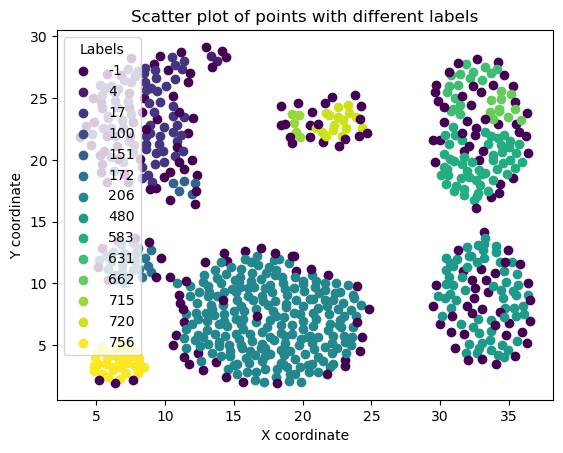

In [13]:
# Plot Test1 result
# Convert the Row objects to dictionaries
data_dicts = [row.asDict() for row in data_rows]

# Get unique labels
labels = sorted(set([d["label"] for d in data_dicts]))

# Create a colormap for labels
cmap = plt.cm.get_cmap("viridis", len(labels))

# Plot the points with different colors based on their label
for d in data_dicts:
    plt.scatter(
        d["value"][0], d["value"][1], color=[cmap(labels.index(d["label"]) / len(labels))]
    )

# Add legend to the plot
handles = [plt.scatter([], [], color=cmap(i / len(labels))) for i in range(len(labels))]
plt.legend(handles, labels, title="Labels", loc="best")

# Show the plot
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Scatter plot of points with different labels")
plt.show()

In [23]:
# Test2 algorithm on circle

# Define the schema
schema = T.StructType([
    T.StructField("id", T.IntegerType(), False),
    T.StructField("value", T.ArrayType(T.FloatType()), False)
])

# Convert the data to the desired format
formatted_data = [(i, [float(x), float(y)]) for i, (x, y) in enumerate(circle, start=1)]

# Create a DataFrame
df_circle = spark.createDataFrame(formatted_data, schema=schema)

#fit DBScan
dfcircle_clusters = process(spark, df_circle, 0.5, 2, dist, 2, "checkpoint")
out = dfcircle_clusters.distinct().select('point','component')

# data_row was used to plot
datacircle_rows  = out.select(out.point.alias('id'),out.component.alias('label')).join(df_circle,'id').collect()

#show result
print(datacircle_rows)


Temporary cluster generation time: 0.42093920707702637


Global cluster generation time: 5.221796035766602
[Row(id=118, label=1, value=[0.7425306439399719, 0.8572012782096863]), Row(id=658, label=1, value=[1.315036416053772, 0.15704114735126495]), Row(id=860, label=751, value=[3.3249824047088623, 3.9712672233581543]), Row(id=1301, label=751, value=[0.30036479234695435, -4.889580249786377]), Row(id=1325, label=751, value=[1.1112316846847534, -4.079751014709473]), Row(id=350, label=1, value=[-0.35324788093566895, 0.9332741498947144]), Row(id=715, label=1, value=[1.3517968654632568, 0.46367281675338745]), Row(id=730, label=1, value=[1.3844939470291138, 0.3053033649921417]), Row(id=1068, label=751, value=[-4.365020751953125, 2.5382444858551025]), Row(id=1194, label=751, value=[-3.5831942558288574, -2.3144407272338867]), Row(id=29, label=1, value=[1.0929352045059204, 0.9658547043800354]), Row(id=58, label=1, value=[0.9721425175666809, 0.5865426063537598]), Row(id=1102, label=751, value=[-4.109068870544434, 0.9989097118377686]), Row(id=1382, label

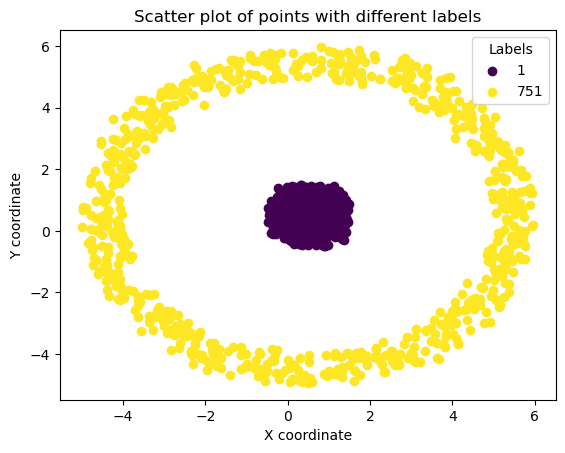

In [16]:
# Plot Test2 result
# Convert the Row objects to dictionaries
data_dicts = [row.asDict() for row in datacircle_rows]

# Get unique labels
labels = sorted(set([d["label"] for d in data_dicts]))

# Create a colormap for labels
cmap = plt.cm.get_cmap("viridis", len(labels))

# Plot the points with different colors based on their label
for d in data_dicts:
    plt.scatter(
        d["value"][0], d["value"][1], color=[cmap(labels.index(d["label"]) / len(labels))]
    )

# Add legend to the plot
handles = [plt.scatter([], [], color=cmap(i / len(labels))) for i in range(len(labels))]
plt.legend(handles, labels, title="Labels", loc="best")

# Show the plot
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Scatter plot of points with different labels")
plt.show()

In [18]:
def ReaddataToDF1(filename):
    """
    Reads data from a file and converts it into a DataFrame.

    :param filename: The name of the file containing the data
    :return: A DataFrame with columns "id" and "value"
    """
    data = spark.read.text(filename).rdd.map(lambda r: r[0].split()).zipWithIndex().map(
        lambda r: Row(id=r[1], value=(float(r[0][0]), float(r[0][1]))))
    schema = T.StructType([
        T.StructField("id", T.IntegerType(), False),
        T.StructField("value", T.ArrayType(T.FloatType()), False)
    ])
    df = spark.createDataFrame(data, schema)
    return df

In [21]:
# Test algorithm on s1.txt(5000 points dataset)

#load data
df = ReaddataToDF1("s1.txt")
#print(df.take(5))
#fit DBScan
start_time = time.time()
df_clusters = process(spark, df, 10000, 10, dist, 2, "checkpoint")
end_time = time.time()
print("Computation time is ", end_time-start_time)

out = df_clusters.distinct().select('point','component')

# data_row was used to plot
data_rows1  = out.select(out.point.alias('id'),out.component.alias('label')).join(df,'id').collect()


Temporary cluster generation time: 0.20262503623962402


Global cluster generation time: 11.06189489364624
Computation time is  11.062122106552124


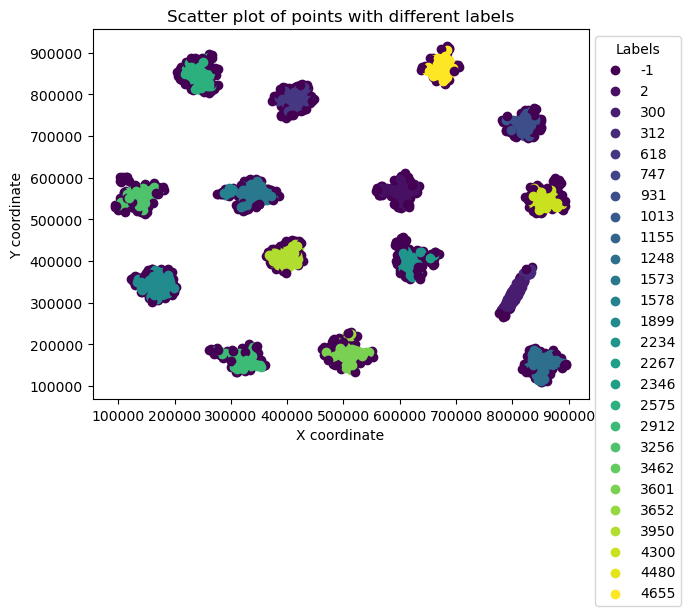

In [22]:
# Plot Test1 result
# Convert the Row objects to dictionaries
data_dicts = [row.asDict() for row in data_rows1]

# Get unique labels
labels = sorted(set([d["label"] for d in data_dicts]))

# Create a colormap for labels
cmap = plt.cm.get_cmap("viridis", len(labels))

# Plot the points with different colors based on their label
for d in data_dicts:
    plt.scatter(
        d["value"][0], d["value"][1], color=[cmap(labels.index(d["label"]) / len(labels))]
    )

# Add legend to the plot
handles = [plt.scatter([], [], color=cmap(i / len(labels))) for i in range(len(labels))]
plt.legend(handles, labels, title="Labels", bbox_to_anchor=(1, 1))

# Show the plot
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Scatter plot of points with different labels")
plt.show()